В этом задании представлена работа с набором данных о качестве вин, который содержит характеристики различных вин и оценки их качества. Задача — создать модель, которая будет предсказывать качество вина на основе его свойств.



**1. Загрузка и предварительная обработка данных**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" #красные вина
url_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv' #белые вина
data_red = pd.read_csv(url_red, sep=";")
data_white = pd.read_csv(url_white, sep=";")
data = pd.concat([data_red, data_white])

Посмотрим на датасет, выведя первые 5 строк

In [ ]:
data.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


Смотрим размер датасета

In [ ]:
data.shape

(6497, 12)

Статистика по данным

In [ ]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Строим гистограммы распределений всех признаков

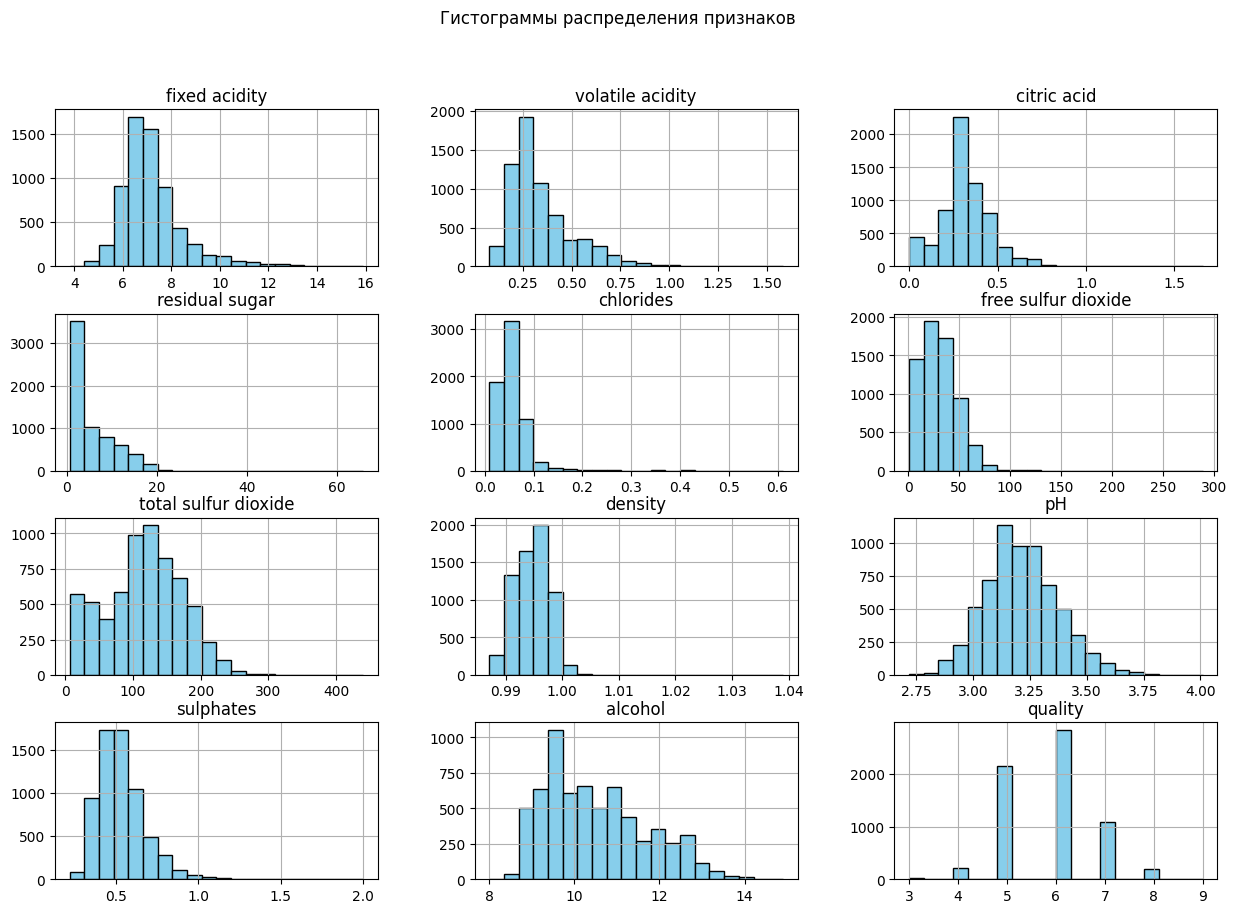

In [ ]:
data.hist(bins=20, figsize=(15, 10), color="skyblue", edgecolor="black")
plt.suptitle("Гистограммы распределения признаков")
plt.show()

Анализ распределения целевой переменной - качества вина. Оценки распределяются от 3 до 9, больше всего оценок 5 и 6

In [ ]:
data['quality'].value_counts()

,count
quality,
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


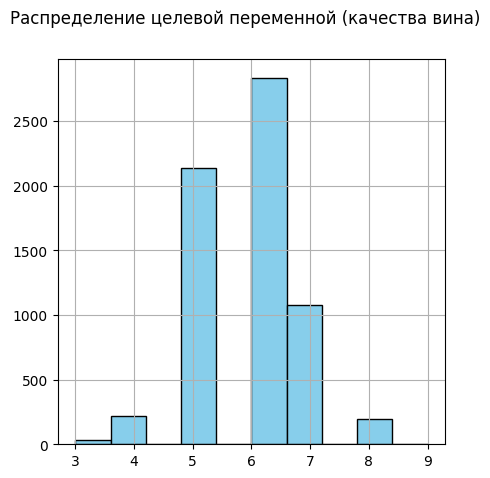

In [ ]:
data['quality'].hist(figsize=(5, 5), color="skyblue", edgecolor="black")
plt.suptitle("Распределение целевой переменной (качества вина)")
plt.show()

Поиск пропусков в данных - пропусков нет

In [ ]:
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Нахождение выбросов в данных

In [ ]:
def detect_outliers(df, features):
    outlier_indices = []
    for feature in features:
        # Вычисление первого и третьего квартилей
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        # Определение индексов выбросов
        outlier_list = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list)
    outlier_indices = list(set(outlier_indices))
    return outlier_indices

target_column = 'quality'
outliers = detect_outliers(data, data.columns[:-1])  # Применяем к данным, исключая последний столбец (целевой)

print(f"\nНайдено {len(outliers)} выбросов в данных")


Найдено 1348 выбросов в данных


Удаляем выбросы

In [ ]:
data = data.drop(outliers, axis=0).reset_index(drop=True)

Нормализуем данные без целевой переменной

In [ ]:
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[data.columns[:-1]] = scaler.fit_transform(data[data.columns[:-1]])

Проверяем нормализованные данные

In [ ]:
data_scaled.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.079268,2.643150,-2.572791,-0.893478,1.289789,-1.077034,-1.295606,0.821636,0.627914,-0.389291,-1.002400,5
1,0.625336,1.766460,0.475001,0.107953,1.409624,-0.949262,-0.426610,1.315256,0.965359,2.540299,-0.094247,5
2,-0.282529,2.467812,-2.369605,-0.848970,2.967470,-1.077034,-1.174351,0.645342,0.492936,0.300024,-1.167519,5
3,0.625336,1.766460,0.475001,0.107953,1.409624,-0.949262,-0.426610,1.315256,0.965359,2.540299,-0.094247,5
4,1.760167,-0.162259,2.506862,-0.848970,2.667884,0.200688,-0.406401,0.997929,0.627914,2.109477,-0.094247,7


Построим корреляционную матрицу

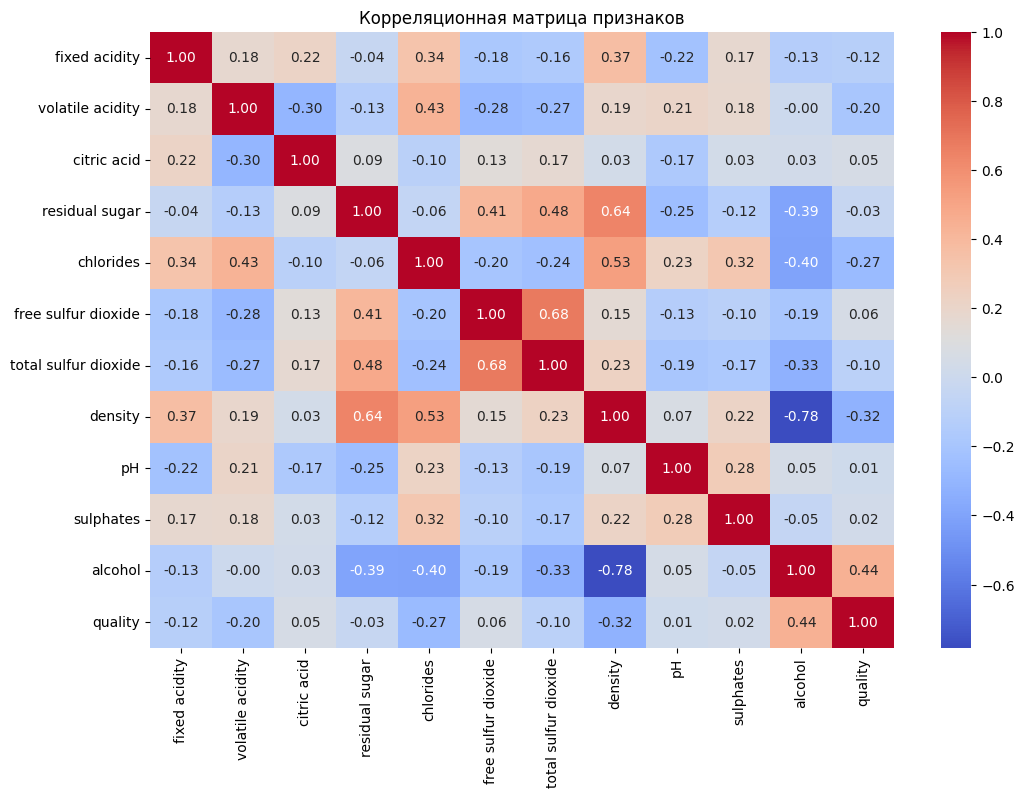

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.show()

Так, мы видим, что признаки total sulfur dioxide и free sulfur dioxide имеют высокую корреляцию между собой и могут быть избыточны для модели. Также важно посмотреть на признаки, имеющие высокую корреляцию с целевой переменной: это признак alcohol

**2. Разработка модели**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

Подготовим данные, разделим на обучающую и тестовую выборку

In [ ]:
X = data_scaled.drop("quality", axis=1).values
y = data_scaled["quality"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Перекодируем значения целевой переменной, так как будем решать задачу классификации: оценки от 3 до 9 переведем на шкалу от 0 до 6

In [ ]:
y_train_class = (y_train - 3).astype(int)  # Сдвиг, чтобы классы начинались с 0
y_test_class = (y_test - 3).astype(int)

Преобразуем данные в тензоры

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_class, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_class, dtype=torch.long)

Реализуем архитектуру сети. В качестве функции активации в скрытых слоях используем ReLU. ReLU популярна в нейронных сетях благодаря способности справляться с проблемой исчезающих градиентов.

In [ ]:
class WineQualityClassifier(nn.Module):
    def __init__(self, input_size):
        super(WineQualityClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 7)  # 7 классов для оценки вина от 3 до 9

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Инициализация модели, функции потерь и оптимизатора. Мы используем кросс-энтропию в качестве функции потерь, она отражает разницу между предсказанным и истинным распределениями вероятностей. Также мы используем оптимизатор Adam. Adam адаптирует скорость обучения (learning rate) для каждого параметра, что делает процесс оптимизации более эффективным.

In [ ]:
input_size = X_train.shape[1]
model = WineQualityClassifier(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Обучение модели с помощью градиентного спуска. Внутри цикла обучения мы последовательно выполняем шаги, которые реализуют градиентный спуск:

1. Прямой проход для предсказаний.
2. Вычисление ошибки (функция потерь).
3. Обратное распространение для расчёта градиентов.
4. Шаг оптимизации. Здесь оптимизатор — это Adam, который является улучшенной версией градиентного спуска. Градиентный спуск работает, снижая потери, что позволяет модели постепенно улучшать свои предсказания.
5. Обнуление градиентов. Без обнуления градиенты будут накапливаться, что приведет к неправильному обновлению весов.


In [ ]:
num_epochs = 2500
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Обратное распространение и оптимизация
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Печать потерь каждые 50 эпох
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/2500], Loss: 1.2150
Epoch [100/2500], Loss: 1.0726
Epoch [150/2500], Loss: 1.0207
Epoch [200/2500], Loss: 0.9911
Epoch [250/2500], Loss: 0.9654
Epoch [300/2500], Loss: 0.9386
Epoch [350/2500], Loss: 0.9111
Epoch [400/2500], Loss: 0.8842
Epoch [450/2500], Loss: 0.8586
Epoch [500/2500], Loss: 0.8335
Epoch [550/2500], Loss: 0.8081
Epoch [600/2500], Loss: 0.7828
Epoch [650/2500], Loss: 0.7572
Epoch [700/2500], Loss: 0.7310
Epoch [750/2500], Loss: 0.7063
Epoch [800/2500], Loss: 0.6830
Epoch [850/2500], Loss: 0.6613
Epoch [900/2500], Loss: 0.6414
Epoch [950/2500], Loss: 0.6231
Epoch [1000/2500], Loss: 0.6071
Epoch [1050/2500], Loss: 0.5922
Epoch [1100/2500], Loss: 0.5787
Epoch [1150/2500], Loss: 0.5655
Epoch [1200/2500], Loss: 0.5529
Epoch [1250/2500], Loss: 0.5414
Epoch [1300/2500], Loss: 0.5306
Epoch [1350/2500], Loss: 0.5191
Epoch [1400/2500], Loss: 0.5079
Epoch [1450/2500], Loss: 0.4977
Epoch [1500/2500], Loss: 0.4878
Epoch [1550/2500], Loss: 0.4785
Epoch [1600/2500], Loss: 0.4

Лосс на тренировочных данных уменьшается, это говорит о том, что модель обучается. Проверим ее качество на тестовых данных.

Оценка качества модели

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predictions = torch.max(test_outputs, 1)  # Выбираем предсказанный класс
    test_predictions = test_predictions.numpy()
    y_test = y_test_tensor.numpy()

# Метрики эффективности
accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6087


**3. Отчет и визуализация**

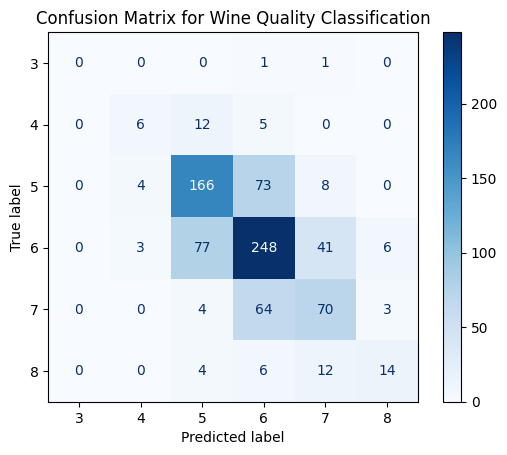

In [ ]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(3, 9))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Wine Quality Classification")
plt.show()

Из матрицы видно, что модель хорошо предсказывает средние значения качества (5 и 6), где сосредоточено большинство данных. Но плохо распознаются реже встречающиеся классы (особенно 3 и 4), путаются соседние классы (например, 5 и 6). Эти проблемы связаны с дисбалансом данных и схожестью признаков соседних классов.

График отношения истинных значений к предсказанным

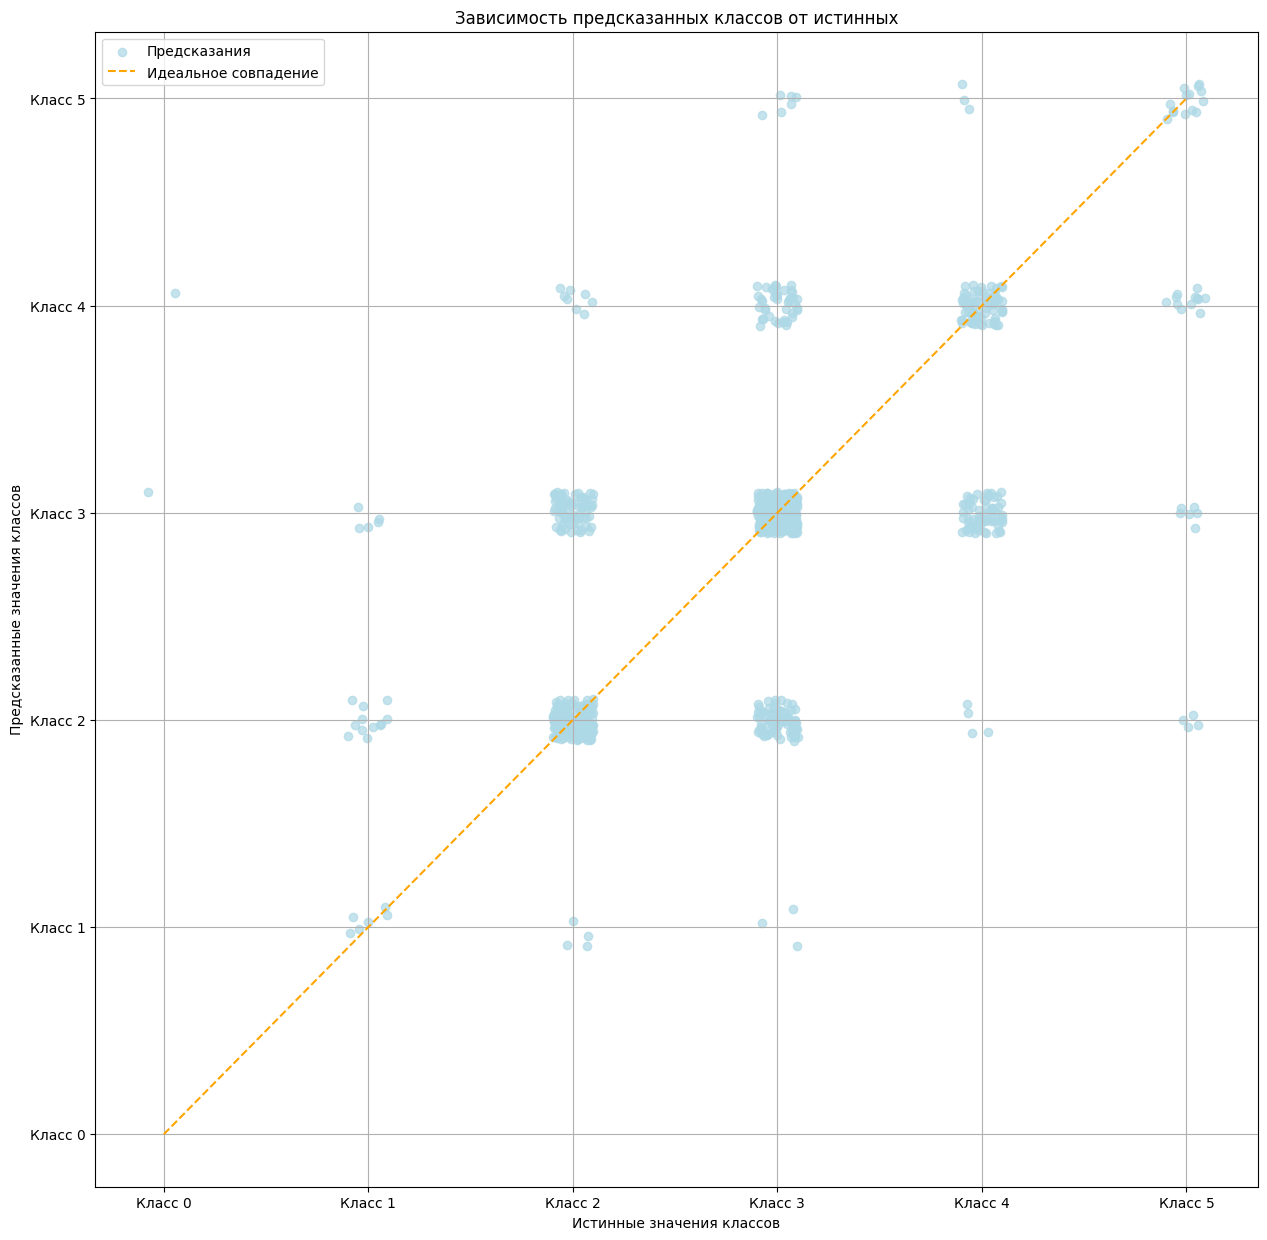

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# немного "шума" для визуализации (так как у нас задача классификации, при визуализации точки сливаются в одну и этот график не информативен)
jitter = 0.1
y_true_jittered = [y + np.random.uniform(-jitter, jitter) for y in y_test]
y_pred_jittered = [y + np.random.uniform(-jitter, jitter) for y in test_predictions]

# Построение графика
plt.figure(figsize=(15, 15))
plt.scatter(y_true_jittered, y_pred_jittered, alpha=0.7, color='lightblue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='--', label='Идеальное совпадение')
plt.xticks(range(6), labels=[f'Класс {i}' for i in range(6)])
plt.yticks(range(6), labels=[f'Класс {i}' for i in range(6)])
plt.xlabel('Истинные значения классов')
plt.ylabel('Предсказанные значения классов')
plt.title('Зависимость предсказанных классов от истинных')
plt.legend()
plt.grid()
plt.show()

Еще одна визуализация отношения истинных значений к предсказанным

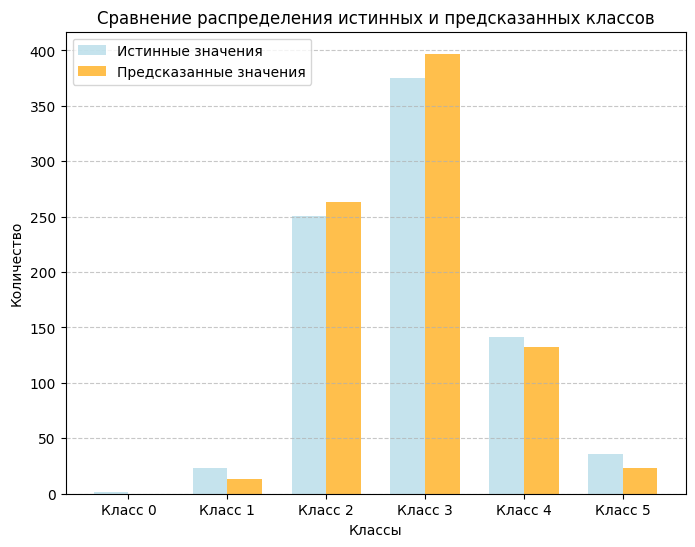

In [ ]:
classes = np.arange(6)
true_counts = [np.sum(y_test == c) for c in classes]
pred_counts = [np.sum(test_predictions == c) for c in classes]

bar_width = 0.35
index = np.arange(len(classes))

plt.figure(figsize=(8, 6))
plt.bar(index, true_counts, bar_width, label='Истинные значения', color='lightblue', alpha=0.7)
plt.bar(index + bar_width, pred_counts, bar_width, label='Предсказанные значения', color='orange', alpha=0.7)
plt.xticks(index + bar_width / 2, labels=[f'Класс {i}' for i in classes])
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Сравнение распределения истинных и предсказанных классов')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Как улучшить модель**

1. Использовать методы для учета дисбаланса классов. Я пробовала добавлять веса при подсчете лосса с помощью compute_class_weight из sklearn.utils.class_weight, но это ухудшило качество модели. Видимо, классы слишком несбалансированы (класса 9 совсем мало: 5 до удаления выбросов, и 2 после).
2. Использовать другие методы борьбы с выбросами. Я пробовала использовать не удаление выбросов, а приведение к среднему признака, предварительно рассчитав его в каждом классе, но это тоже ухудшило качество модели, поэтому оставила изначальный вариант с нормальным качеством.
3. Улучшить архитектуру модели или использовать другую модель: добавление более сложной архитектуры, либо использование других методов, таких как ансамбли моделей.
4. Подобрать гиперпараметры: добавить слои, поэкспериментировать с количеством нейронов в каждом слое, попробовать другие функции активации (Leaky ReLU, Tanh, или Sigmoid), тип оптимизатора, параметры оптимизатора, менять learning_rate